In [ ]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn
!pip install Sastrawi
!pip install openpyxl
!pip install emoji

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import nltk

# --- Pastikan resource NLTK sudah diunduh ---
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Mengunduh NLTK 'punkt'...")
    nltk.download('punkt')
    print("'punkt' berhasil diunduh.")

# Mengunduh stopwords (penting untuk langkah selanjutnya)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Mengunduh NLTK 'stopwords'...")
    nltk.download('stopwords')
    print("'stopwords' berhasil diunduh.")

from google_play_scraper import app, Sort, reviews_all
from textblob import TextBlob
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # Tidak perlu specify language di sini
from nltk.probability import FreqDist

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15,10)

print("Memulai proses scraping data review...")

Memulai proses scraping data review...


In [ ]:
# Scrapping reviews
mymrtj_reviews = reviews_all(
    'com.mrt.jakarta',
    sleep_milliseconds=0,
    lang='id',
    sort=Sort.NEWEST,
)

# Simpan review MyMRTJ ke dalam dataframe
df_mymrtjrev = pd.DataFrame(np.array(mymrtj_reviews),columns=['content'])
df_mymrtjrev = df_mymrtjrev.join(pd.DataFrame(df_mymrtjrev.pop('content').tolist()))

# --- Simpan Data Mentah ke CSV dan Excel ---
df_mymrtjrev.to_csv('raw_reviews.csv', index=False)
df_mymrtjrev.to_excel('raw_reviews.xlsx', index=False)
print("Data mentah berhasil disimpan ke raw_reviews.csv dan raw_reviews.xlsx")

Data mentah berhasil disimpan ke raw_reviews.csv dan raw_reviews.xlsx



Informasi DataFrame awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   content               1399 non-null   object        
 1   score                 1399 non-null   int64         
 2   thumbsUpCount         1399 non-null   int64         
 3   reviewCreatedVersion  1237 non-null   object        
 4   at                    1399 non-null   datetime64[ns]
 5   replyContent          45 non-null     object        
 6   repliedAt             45 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 76.6+ KB

Distribusi skor review:
score
5    855
1    299
4    116
3     68
2     61
Name: count, dtype: int64


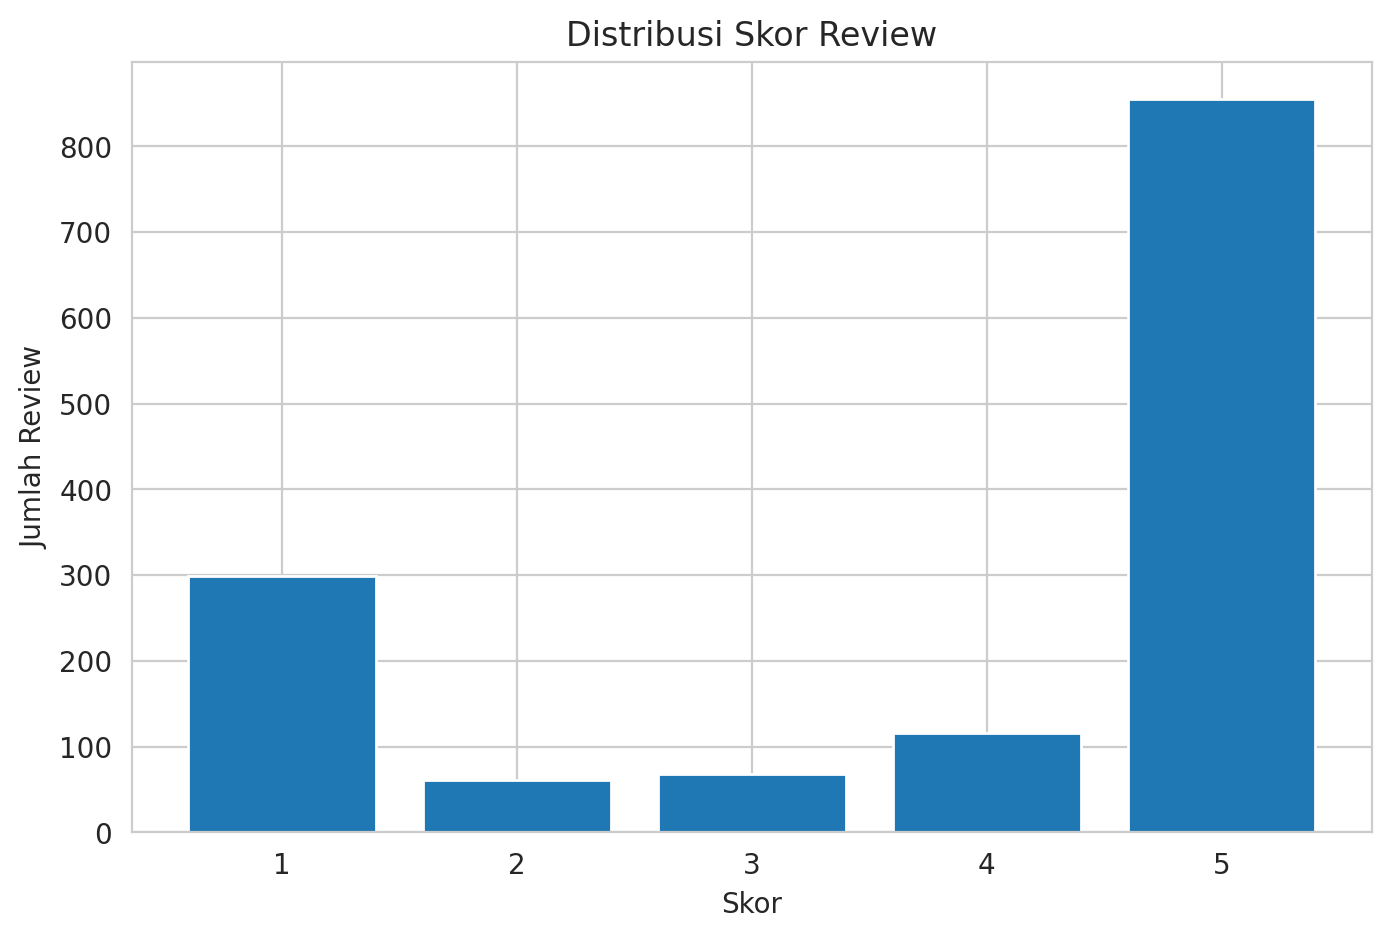

In [ ]:
# Kolom yang tidak diperlukan untuk analisis sentimen
df_mymrtjrev_filtered = df_mymrtjrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]
print("\nInformasi DataFrame awal:")
df_mymrtjrev_filtered.info()

# Cek jumlah skor review
print("\nDistribusi skor review:")
print(df_mymrtjrev['score'].value_counts())
plt.figure(figsize=(8, 5))
plt.hist(df_mymrtjrev['score'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.8)
plt.title('Distribusi Skor Review')
plt.xlabel('Skor')
plt.ylabel('Jumlah Review')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [ ]:
# --- Preprocessing Pipeline ---
import nltk

# Download resource untuk tokenisasi
nltk.download('punkt')
nltk.download('punkt_tab')

# Membuat salinan dataframe untuk proses preprocessing
df_processed = df_mymrtjrev.copy()

# 1. Lower casing: Mengubah semua teks menjadi huruf kecil
df_processed['content'] = df_processed['content'].astype(str).apply(lambda x: x.lower())
print("\nLangkah 1/6: Lowercasing selesai.")

# 2. Expand Contractions: Mengembangkan singkatan umum Bahasa Indonesia
# Contoh singkatan informal dan padanannya
contraction_mapping = {
    "yg": "yang", "udah": "sudah", "ga": "tidak", "gak": "tidak",
    "bgt": "banget", "bgtt": "banget", "jg": "juga", "aja": "saja",
    "bkn": "bukan", "tdk": "tidak", "jd": "jadi", "tp": "tapi",
    "gk": "tidak", "blm": "belum", "sdh": "sudah", "krn": "karena",
    "dgn": "dengan", "utk": "untuk", "sampe": "sampai", "udh": "sudah",
    "dr": "dari", "dlm": "dalam", "bbrp": "beberapa", "bs": "bisa",
    "mrt": "mass rapid transit", # contoh: bisa diganti jika ingin mempertahankan 'mrt'
    "app": "aplikasi" # contoh
}

def expand_contractions(text, mapping):
    words = text.split()
    expanded_words = [mapping[word] if word in mapping else word for word in words]
    return ' '.join(expanded_words)

df_processed['content'] = df_processed['content'].apply(lambda x: expand_contractions(x, contraction_mapping))
print("Langkah 2/6: Expand Contractions selesai.")

# 3. Punctuations Removal: Menghapus tanda baca
df_processed['content'] = df_processed['content'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
print("Langkah 3/6: Punctuations Removal selesai.")

# 4. Tokenization: Memecah teks menjadi kata-kata
# Hapus `language='indonesian'`
df_processed['tokens'] = df_processed['content'].apply(word_tokenize)
print("Langkah 4/6: Tokenization selesai.")
print("Contoh token setelah tokenisasi:", df_processed['tokens'].head(2).tolist())

# 5. Stopword Removal: Menghapus kata-kata tidak penting (stopword)
# Stopword Bahasa Indonesia dari Sastrawi dan NLTK
factory_stopword = StopWordRemoverFactory()
sastrawi_stopwords = factory_stopword.get_stop_words()
indonesian_stopwords_nltk = stopwords.words('indonesian')

# Stopword Bahasa Inggris dari NLTK
english_stopwords = stopwords.words('english')

# Custom stopwords (dapat ditambahkan/disesuaikan berdasarkan analisis frekuensi kata)
custom_stopwords = [
    'yg', 'bs', 'tyt', 'aja', 'loh', 'deh', 'dong', 'sih', 'nya', 'nih', 'udah',
    'bgt', 'banget', 'gak', 'ga', 'gk', 'jg', 'mrtj', 'mrt', 'aplikasi', 'review',
    'halo', 'admin', 'kak', 'min', 'hi', 'hai', 'terima', 'kasih', 'bantu'
]

# Gabungkan semua stopword menjadi satu set agar pencarian lebih cepat
all_stopwords = set(sastrawi_stopwords + indonesian_stopwords_nltk + english_stopwords + custom_stopwords)

df_processed['tokens_no_stopwords'] = df_processed['tokens'].apply(
    lambda x: [word for word in x if word not in all_stopwords and len(word) > 1 and not word.isdigit()]
) # Menghapus stopword, token 1 karakter, dan angka
print("Langkah 5/6: Stopword Removal (Indonesia, Inggris, dan kustom) selesai.")
print("Contoh token setelah stopword removal:", df_processed['tokens_no_stopwords'].head(2).tolist())

# 6. Stemming: Mengubah kata menjadi bentuk dasar menggunakan Sastrawi
factory_stemmer = StemmerFactory()
sastrawi_stemmer = factory_stemmer.create_stemmer()

def sastrawi_stem(word_list):
    return [sastrawi_stemmer.stem(word) for word in word_list]

df_processed['tokens_stemmed'] = df_processed['tokens_no_stopwords'].apply(sastrawi_stem)
print("Langkah 6/6: Stemming (menggunakan Sastrawi) selesai.")
print("Contoh token setelah stemming:", df_processed['tokens_stemmed'].head(2).tolist())

# Menggabungkan kembali token menjadi teks bersih final
df_processed['clean_text_final'] = df_processed['tokens_stemmed'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Langkah 1/6: Lowercasing selesai.
Langkah 2/6: Expand Contractions selesai.
Langkah 3/6: Punctuations Removal selesai.
Langkah 4/6: Tokenization selesai.
Contoh token setelah tokenisasi: [['ke', 'balik', 'milih', 'setasiun', 'buat', 'masuk', 'sudah', 'nyamperin', 'petugasnya', 'buat', 'nanya', 'ini', 'masih', 'bisa', 'di', 'ganti', 'gak', 'katanya', 'tidak', 'bisa', 'terus', 'bilang', 'itu', 'tanggung', 'jawab', 'sendiri', 'jadi', 'harus', 'mesen', 'lg', 'jadinya', 'tiket', 'sebelum', 'tidak', 'ke', 'pake', 'sama', 'sekali'], ['tidak', 'bisa', 'bayar', 'pakai', 'qris']]
Langkah 5/6: Stopword Removal (Indonesia, Inggris, dan kustom) selesai.
Contoh token setelah stopword removal: [['milih', 'setasiun', 'masuk', 'nyamperin', 'petugasnya', 'nanya', 'ganti', 'bilang', 'tanggung', 'mesen', 'lg', 'tiket', 'pake'], ['bayar', 'pakai', 'qris']]
Langkah 6/6: Stemming (menggunakan Sastrawi) selesai.
Contoh token setelah stemming: [['milih', 'setasiun', 'masuk', 'nyamperin', 'tugas', 'nanya', 'ga

In [ ]:
# --- Rare Words Removal ---
all_words_clean = ' '.join(df_processed['clean_text_final']).split()
fdist_clean = FreqDist(all_words_clean)

# Ambang batas untuk kata-kata jarang (misalnya, muncul kurang dari 3 kali)
rare_words_threshold = 3
rare_words = set(word for word, count in fdist_clean.items() if count < rare_words_threshold)

def remove_rare_words(text_list, rare_words_set):
    return [word for word in text_list if word not in rare_words_set]

df_processed['tokens_final_filtered'] = df_processed['tokens_stemmed'].apply(
    lambda x: remove_rare_words(x, rare_words)
)
df_processed['clean_text_final'] = df_processed['tokens_final_filtered'].apply(lambda x: ' '.join(x))
print("Langkah opsional: Penghapusan kata-kata jarang selesai.")

Langkah opsional: Penghapusan kata-kata jarang selesai.


In [ ]:
# --- Hitung sentimen sebelum menyimpan data bersih ---
# Ini menggunakan kolom 'content' asli untuk konsistensi dengan visualisasi awal.
df_processed['sentiment_polarity'] = df_mymrtjrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_processed['sentiment_subjective'] = df_mymrtjrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)
df_processed['sentiment_rating'] = df_mymrtjrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3 else 'Negative'))

In [ ]:
# --- Simpan Data Bersih ke CSV dan Excel ---
df_processed_final = df_processed.loc[:, ["content", "score", "sentiment_polarity", "sentiment_subjective", "sentiment_rating", "clean_text_final"]]
df_processed_final.to_csv('cleandata.csv', index=False)
df_processed_final.to_excel('cleandata.xlsx', index=False)
print("\nData bersih berhasil disimpan ke cleandata.csv dan cleandata.xlsx")

# Tampilkan sampel data yang sudah bersih
print("\nSampel data setelah preprocessing:")
print(df_processed_final.head())


Data bersih berhasil disimpan ke cleandata.csv dan cleandata.xlsx

Sampel data setelah preprocessing:
                                             content  score  \
0  ke balik milih setasiun buat masuk sudah nyamp...      1   
1                        tidak bisa bayar pakai qris      1   
2  sukaa dari segi pembayaran masih dipermudah se...      5   
3                   lemot banget dana di saldo ilang      1   
4                                      hmmmm lumayan      3   

   sentiment_polarity  sentiment_subjective sentiment_rating  \
0                 0.0              0.000000         Negative   
1                 0.0              0.000000         Negative   
2                 0.0              0.357143         Positive   
3                 0.0              0.000000         Negative   
4                 0.0              0.000000          Neutral   

                                    clean_text_final  
0             masuk tugas ganti bilang lg tiket pake  
1                      

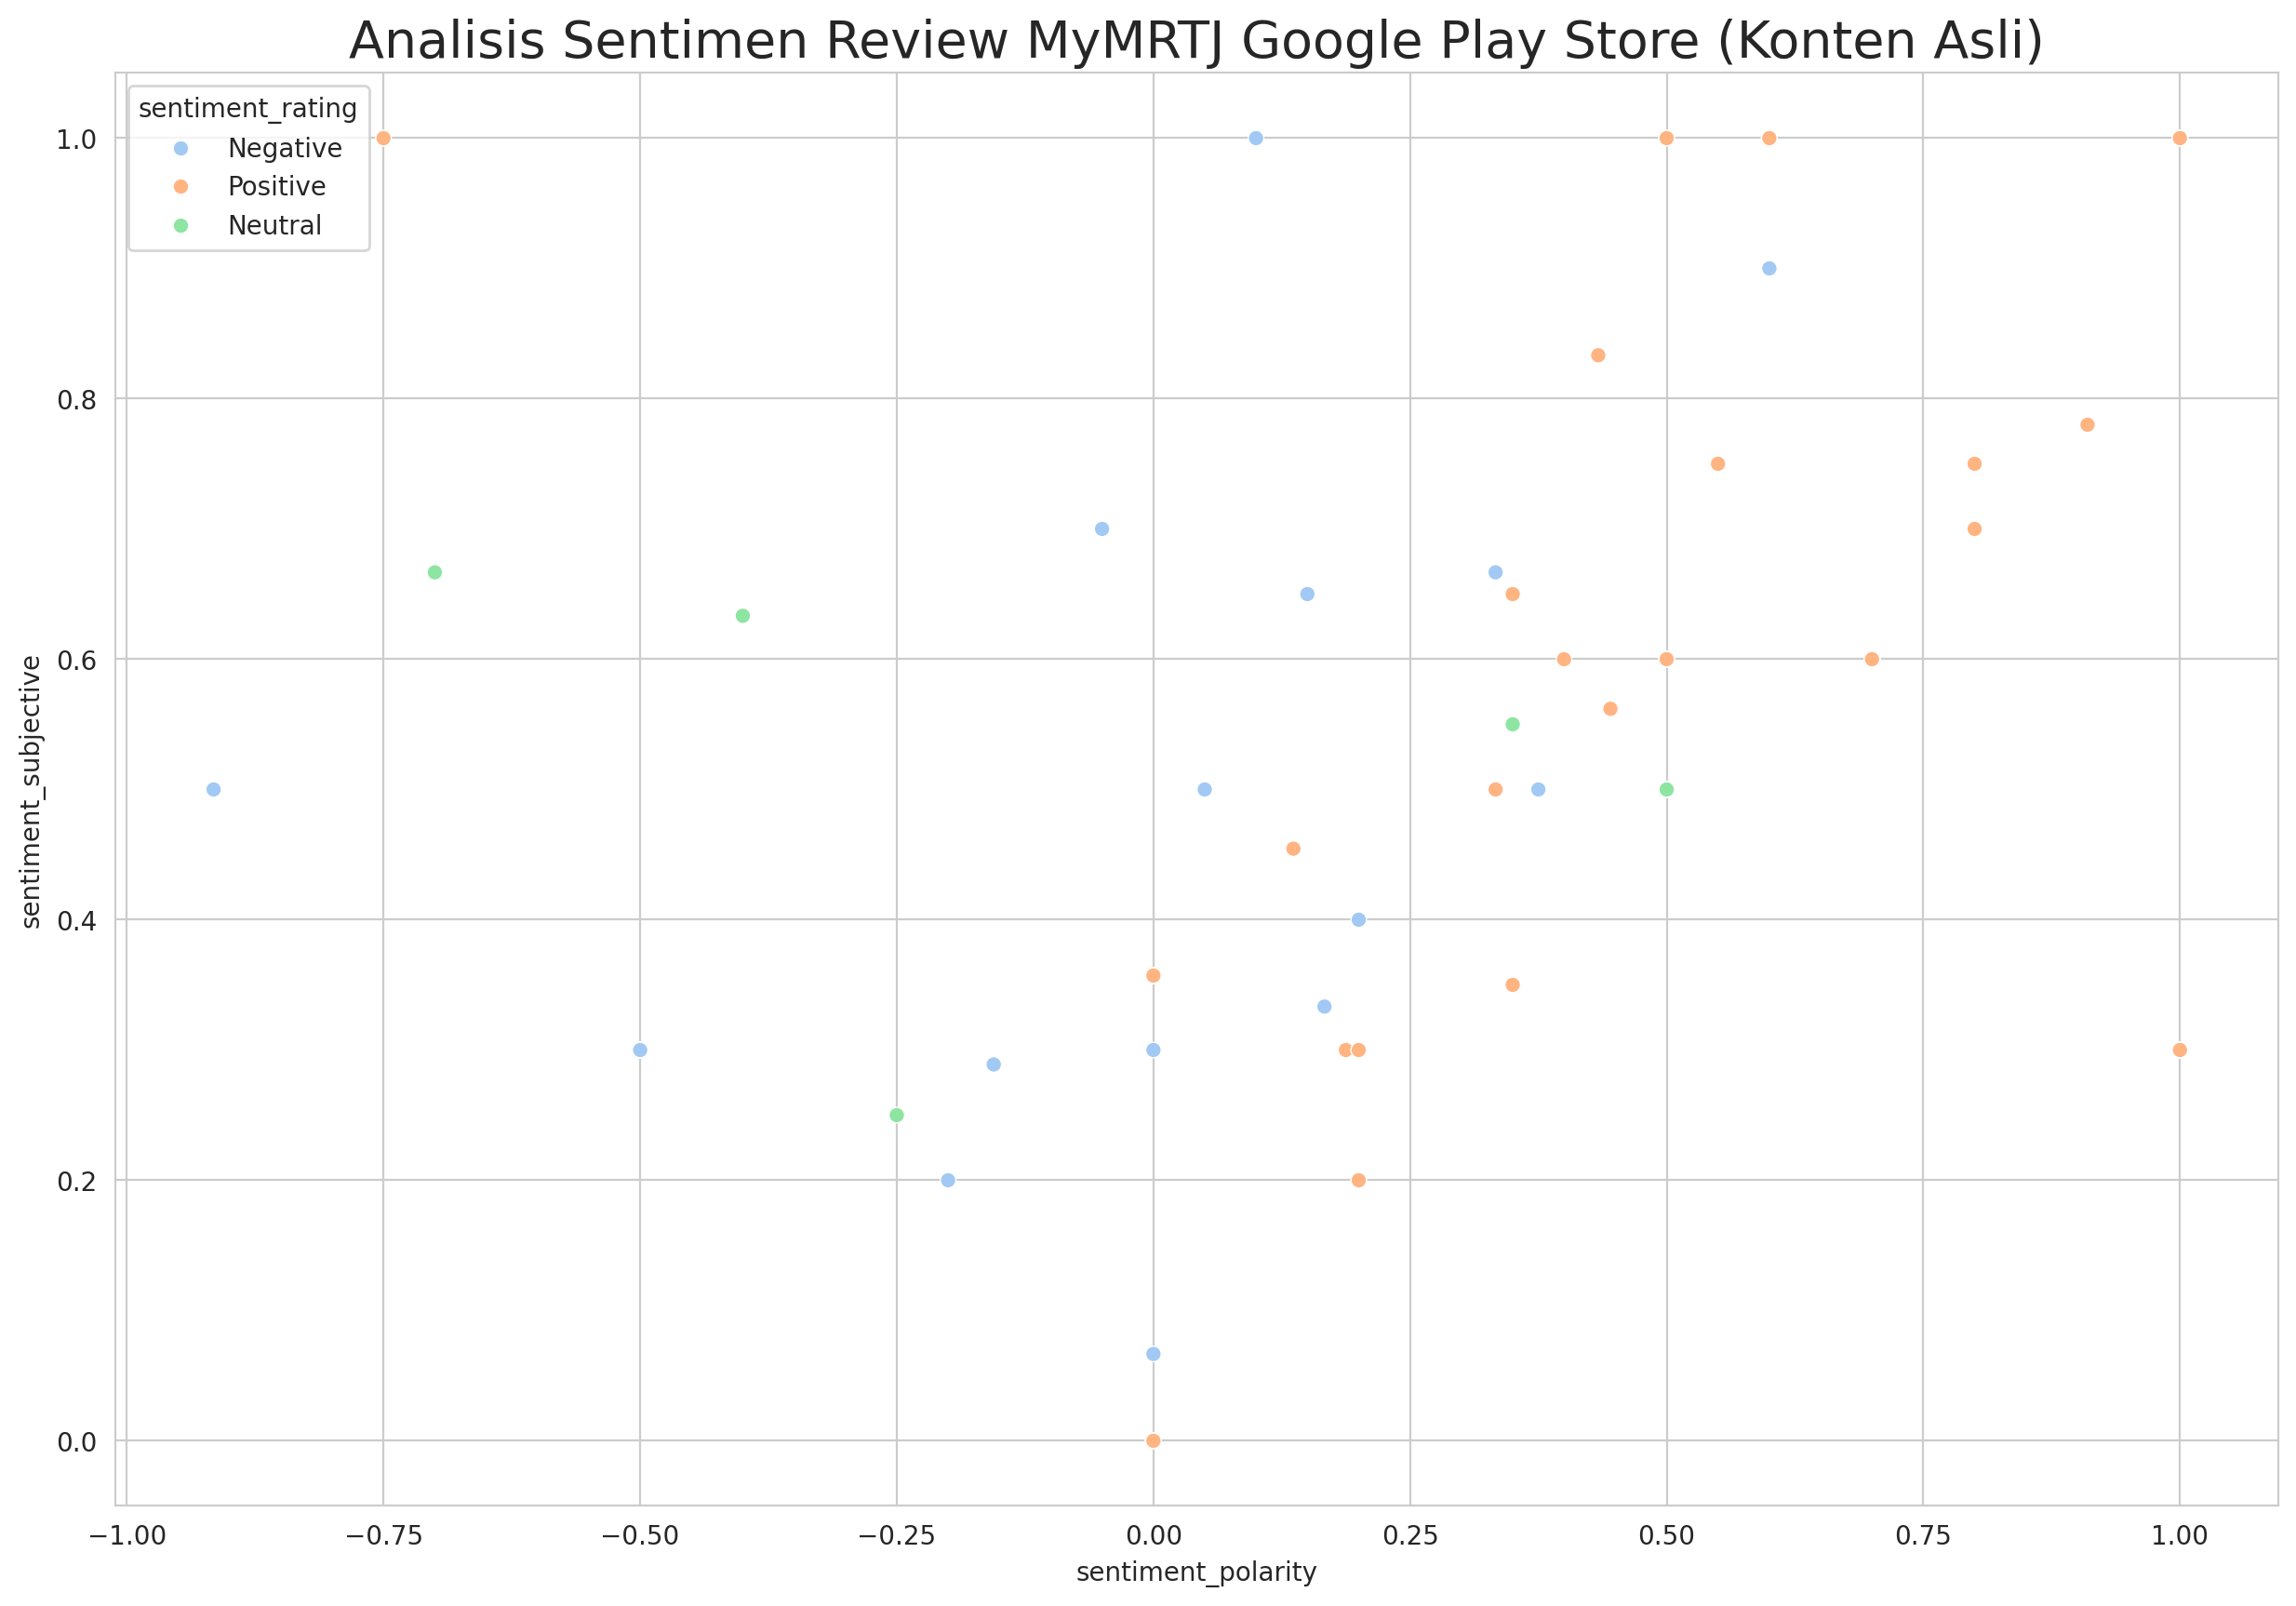

In [ ]:
# --- Analisis Sentimen Awal (pada konten asli) ---
plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_processed_final['sentiment_polarity'], y=df_processed_final['sentiment_subjective'], hue=df_processed_final['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Analisis Sentimen Review MyMRTJ Google Play Store (Konten Asli)", fontsize=20)
plt.show()

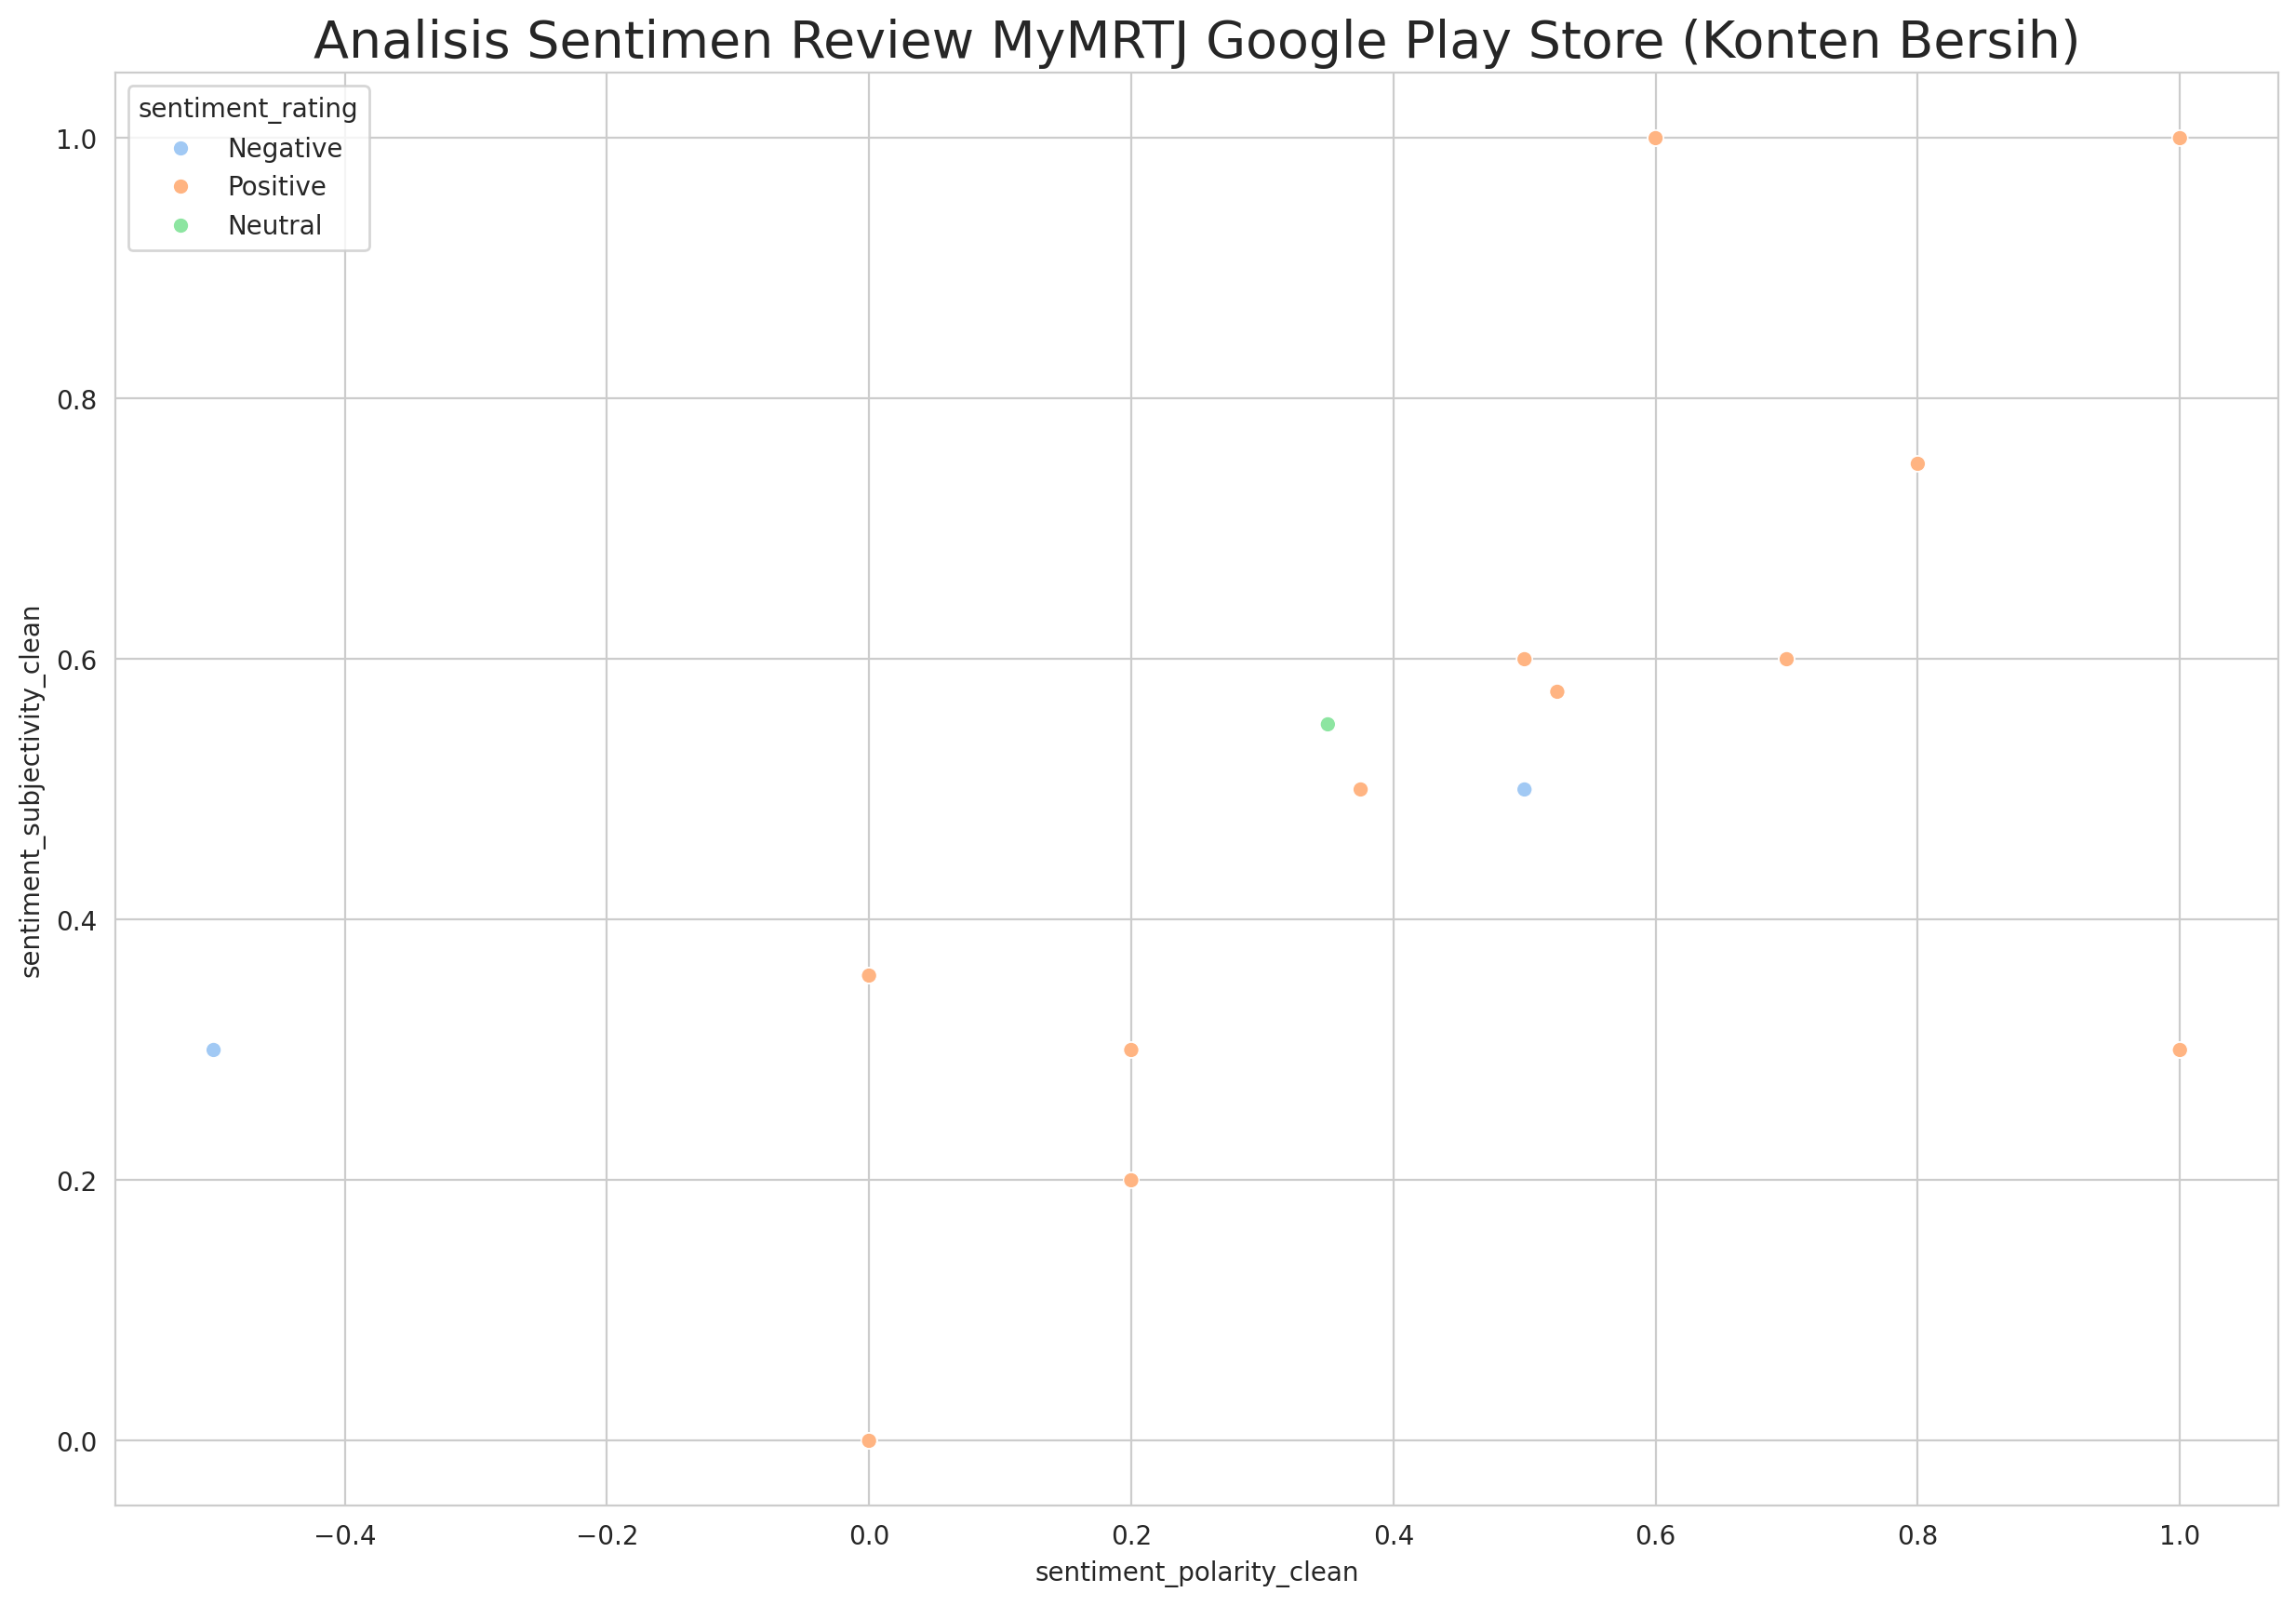

In [ ]:
# --- Analisis Sentimen dengan Teks Bersih (Opsional, dengan catatan) ---
df_processed_final['sentiment_polarity_clean'] = df_processed_final['clean_text_final'].apply(lambda x: TextBlob(x).polarity)
df_processed_final['sentiment_subjectivity_clean'] = df_processed_final['clean_text_final'].apply(lambda x: TextBlob(x).subjectivity)

plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_processed_final['sentiment_polarity_clean'], y=df_processed_final['sentiment_subjectivity_clean'], hue=df_processed_final['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Analisis Sentimen Review MyMRTJ Google Play Store (Konten Bersih)", fontsize=20)
plt.show()


--- Analisis Kata Sering Muncul dari Teks yang Sudah Bersih ---

Kata-kata Paling Sering Muncul (n=50):
             word  count
74          bagus    146
7           bayar    139
145          mass    133
146         rapid    133
147       transit    133
22           good     90
10          mudah     87
104        mantap     87
5           tiket     76
6            pake     71
89           beli     71
68          bantu     64
257         keren     54
8           pakai     49
44           coba     49
54          gopay     49
100        daftar     46
160       jakarta     39
0           masuk     38
30           moga     37
39           guna     36
49         metode     35
85         nyaman     34
173      aplikasi     34
63           kode     33
103  transportasi     32
124         ribet     31
64            otp     30
138           ovo     30
225          akun     30
29        stasiun     28
52          jalan     28
11           dana     26
102         error     26
123         cepat   

/tmp/ipython-input-4042145759.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


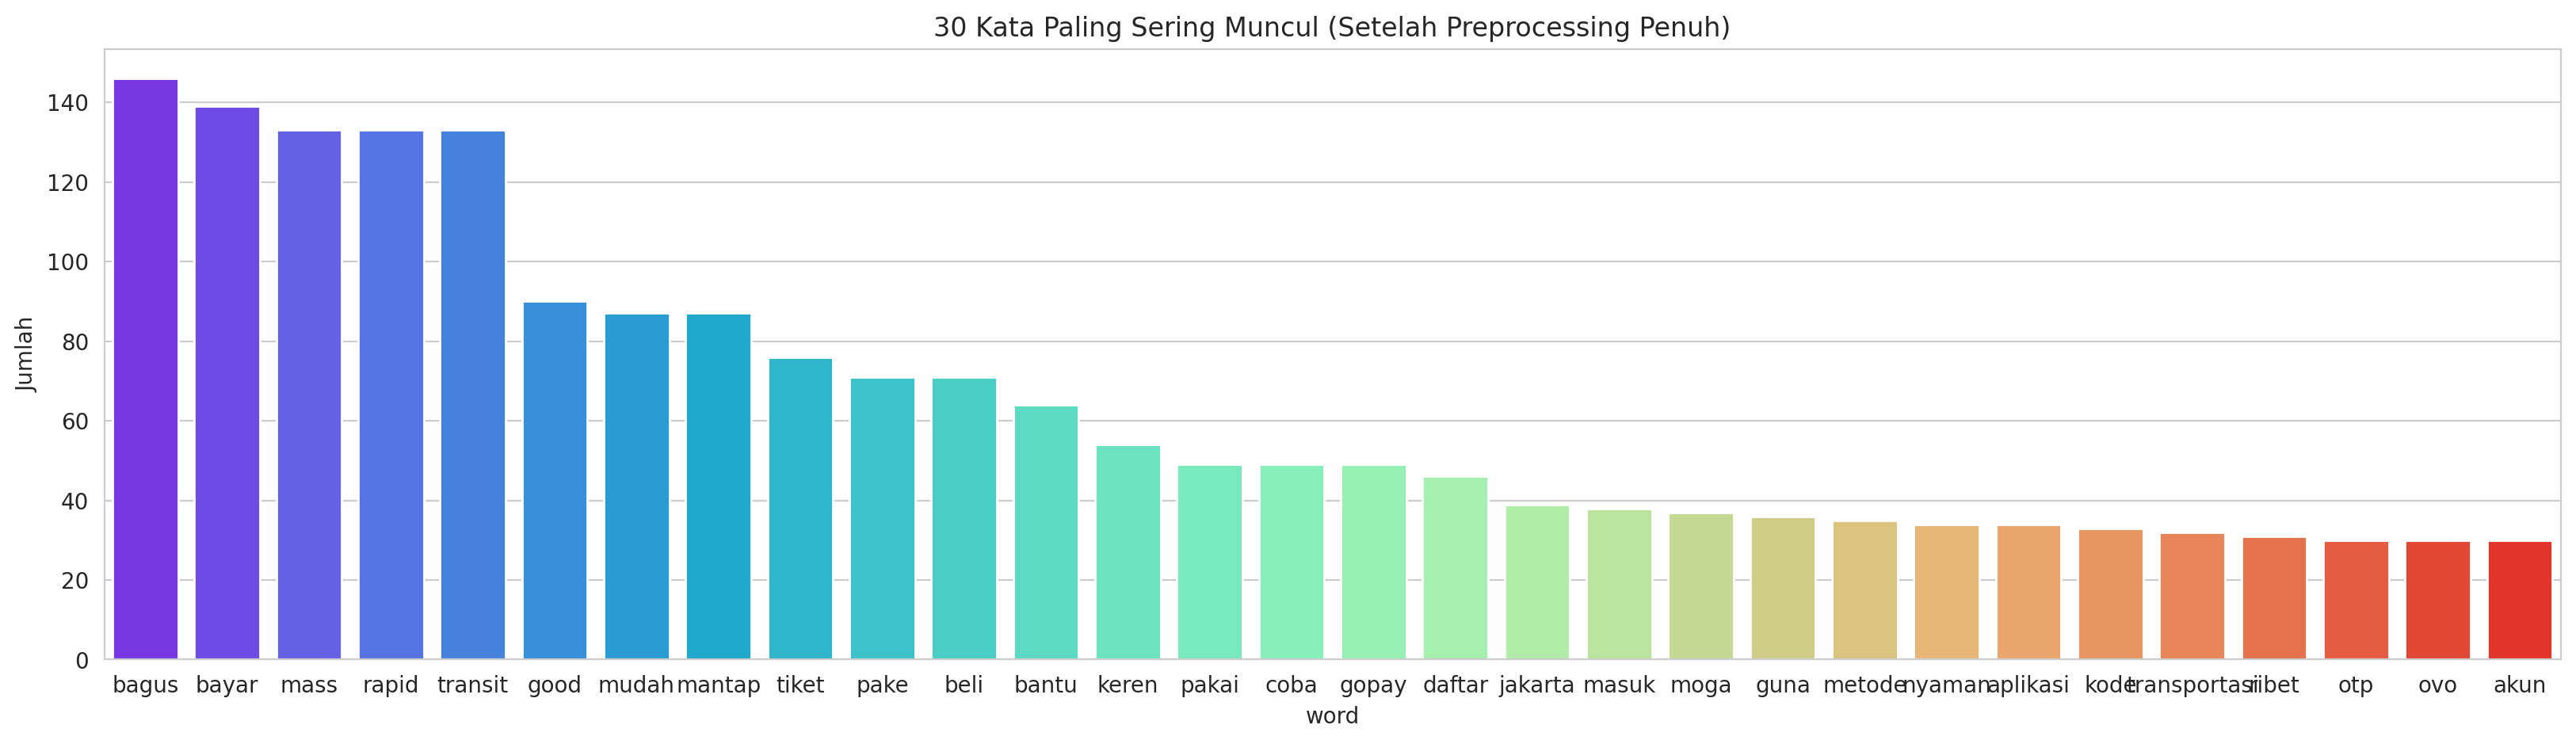


Pipeline preprocessing NLP telah selesai. 'cleandata.csv' dan 'cleandata.xlsx' berisi data yang telah diproses.
Analisis kata-kata yang sering muncul dapat digunakan untuk penyempurnaan stopword kustom di masa mendatang.
Catatan: Untuk analisis sentimen Bahasa Indonesia yang lebih akurat, pertimbangkan penggunaan model sentimen khusus Bahasa Indonesia.


In [ ]:
# --- Analisis Kata Sering Muncul (Frequent Words) dari Teks Bersih ---
print("\n--- Analisis Kata Sering Muncul dari Teks yang Sudah Bersih ---")
all_words_final_processed = ' '.join(df_processed_final['clean_text_final']).split()
fdist_final_processed = FreqDist(all_words_final_processed)
words_df_final_processed = pd.DataFrame({'word':list(fdist_final_processed.keys()), 'count':list(fdist_final_processed.values())})

# Tampilkan kata-kata paling sering muncul (n=50)
print("\nKata-kata Paling Sering Muncul (n=50):")
print(words_df_final_processed.nlargest(columns="count", n=50))

# Tampilkan kata-kata paling sering muncul (n=100)
print("\nKata-kata Paling Sering Muncul (n=100):")
print(words_df_final_processed.nlargest(columns="count", n=100))

# Tampilkan kata-kata paling sering muncul (n=1000)
print("\nKata-kata Paling Sering Muncul (n=1000):")
print(words_df_final_processed.nlargest(columns="count", n=1000))

# Fungsi untuk memplot kata-kata yang paling sering muncul
def plot_freq_words(df_words, terms = 30, title="Kata-kata Paling Sering Muncul"):
    d = df_words.nlargest(columns="count", n = terms)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
    ax.set(ylabel = 'Jumlah', title = title)
    plt.show()

plot_freq_words(words_df_final_processed, terms=30, title="30 Kata Paling Sering Muncul (Setelah Preprocessing Penuh)")

print("\nPipeline preprocessing NLP telah selesai. 'cleandata.csv' dan 'cleandata.xlsx' berisi data yang telah diproses.")
print("Analisis kata-kata yang sering muncul dapat digunakan untuk penyempurnaan stopword kustom di masa mendatang.")
print("Catatan: Untuk analisis sentimen Bahasa Indonesia yang lebih akurat, pertimbangkan penggunaan model sentimen khusus Bahasa Indonesia.")